In [1]:
import torch
import torch.nn as nn
import torchvision  #Para conjuntos de datos y operaciones con imágenes
import torchvision.transforms as transforms  #Para transformaciones de datos
import matplotlib.pyplot as plt  #Para visualización
import numpy as np
from sklearn.metrics import classification_report
import random as rd
import torch.optim as optim

#1. Modelo AlexNet en PyTorch

##1.1 Creación de los bloques Convolucionales y Densos
Vamos a definir el modelo AlexNet en PyTorch, para ello debemos de definir:
1. Bloque Convolucional (tendrá una capa convolucional y una función de activación).
2. Bloque de denso (serán neuronas conectadas con una salida y una funcion de activación).

Para el **Bloque Convoucional**, agregamos una capa convolucional que se encargara de extraer las caracteristicas de las imagenes proporcionadas (como los bordes) con canales de entrada (para imagenes a colo son 3 RGB), los canales de salida (numero de caracteristicas a extarer), un tamaño del kernel (se encarga de recorrer la imagen, por ejemplo, de 3x3 pixeles recorre la imagen y es menos costo computacional), el pading  relleno (al ser igual a 1 mantiene la imagen en su tamaño original) y al final lo que se obtiene se pasa por la finción de activación ReLU.

El **Bloque denso** se encargara de recibir caracteristicas, para nuestro fin seran las caracteristicas extraidas por la CNN. El hecho de que sea lineal quiere decir que todas las neuronas estan conectadas.
Se reciben las caracteristicas y produce una salida que en nuestro caso será 10 para el dataset de _CIFAR 10_ y al final le aplicamos a la salida la función de activación ReLU.


In [2]:
#Capa de convolución
class BloqueConvolucional(nn.Module):
    def __init__(self, canales_entrada, canales_salida, tamaño_kernel=3, relleno=1):
        super(BloqueConvolucional, self).__init__()
        #Capa convolucional que extrae características de la imagen
        self.convolucion = nn.Conv2d(canales_entrada, canales_salida, tamaño_kernel, padding=relleno)
        #Función de activación ReLU
        self.activacion = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.activacion(self.convolucion(x))#Aplicar convolución seguida de ReLU

#Capa densa
class BloqueDenso(nn.Module):
    def __init__(self, caracteristicas_entrada, caracteristicas_salida):
        super(BloqueDenso, self).__init__()
        self.lineal = nn.Linear(caracteristicas_entrada, caracteristicas_salida)
        self.activacion = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.activacion(self.lineal(x))

##1.2 Definición del modelo AlexNet
Para el modelo, debemos de usar 5 capas convolucionales, 3 capas max poooling y 3 capas densas.
Primero extaremos las caracteristicas mediante la primera capa convolucional con 3 canales de entrada para los datos RGB que van aumentando mientras se avanza por las 5 capas convolucionales pero con las caps Maxpooling tambien vamos reduciendo el tamaño de las imagenes quedandonos con varias caracteristicas en menos pixeles. Hasta este punto tenemos 5 capas convolucionales + 3 capas Maxpooling = 8 capas.

Para el segundo bloque de capas, usamos las capas densas para recibir los tensores los cuales los aplana hacia la capa densa 2 donde llegan solo vectores y depues se pasan a la última capa para clasificación, que en el caso de la base de datos, donde son 10 clases donde se puede clasificar las imagenes. Todo eso lo juntamos en el _**forward**_.

In [3]:
#Red AlexNet(PyTorch)
class AlexNet(nn.Module):
    def __init__(self, numero_clases=10):
        super(AlexNet, self).__init__()

        #Capas convolucionales para extracción de características
        self.caracteristicas = nn.Sequential(
            BloqueConvolucional(3, 96), #Conv1: entrada RGB (3 canales)
            nn.MaxPool2d(kernel_size=3, stride=2), #Reducción dimensional con MaxPool1
            BloqueConvolucional(96, 256), #Conv2
            nn.MaxPool2d(kernel_size=3, stride=2), #Reducción dimensional con MaxPool2
            BloqueConvolucional(256, 384), #Conv3
            BloqueConvolucional(384, 384), #Conv4
            BloqueConvolucional(384, 256), #Conv5
            nn.MaxPool2d(kernel_size=3, stride=2) #Reducción dimensional con MaxPool3
        )

        #Capas para clasificación
        self.clasificador = nn.Sequential(
            BloqueDenso(256 * 3 * 3, 4096), #Capa densa 1 (aplanar salidas anteriores)
            BloqueDenso(4096, 4096),        #Capa densa 2
            nn.Linear(4096, numero_clases)  #Capa densa 3 (salida)
        )

    def forward(self, x):
        x = self.caracteristicas(x) #Procesar con capas convolucionales
        x = torch.flatten(x, 1)     #Aplanar tensor
        x = self.clasificador(x)    #Procesar con capas densas
        return x

##1.3 Cargar la base de datos
Descargamos la base y esta se guardara en la ruta indicada, separamos en conjuntos de entrenamiento (para entrenar el modelo de Red) y en conjunto de prueba (se utiliara para ver como se desempeña el modelo ante datos nuevos). Cuando los utilicemos debemos de normalizar los pixeles y vamos a utilizar un batch de 30 (son los datos que se van pasando al modelo, en este caso de 30 en 30).

In [4]:
#Cargar CIFAR-10
transformar = transforms.Compose([
    transforms.ToTensor(), #Convertir imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalizar píxeles a [-1, 1]
])

#Conjunto de entrenamiento
conjunto_entrenamiento = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transformar)
#Cargador de datos en lotes de 30
cargador_entrenamiento = torch.utils.data.DataLoader(conjunto_entrenamiento, batch_size=30, shuffle=True)

#Conjunto de prueba
conjunto_prueba = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transformar)
#Cargador de datos en lotes de 30
cargador_prueba = torch.utils.data.DataLoader(conjunto_prueba, batch_size=30, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#1.4 Entrenar el modelo
Definimos como **modelo1** el modelo de AlexNet y usamos:
- Función de perdida: Entropia cruzada (usualmente empleada en modelos de clasificación)
- Optimizador de la función de perdida: Descenso del Gradiente Estocastico (es más lento que adam pero es más preciso con más iteraciones que adam) con una tasa de aprendizaje de 0.001. Se prefirio SGD ya que, si bien se tenia un menor error de entrenamiento, en el error de prueba se obteneian peores resultados.
- 20 épocas o iteraciones para entrenar el modelo.

Además, vamos a usar el CPU o GPU, dependiendo de nuestra PC.

In [5]:
#Inicializar modelo, función de pérdida y optimizador
modelo1 = AlexNet()
criterio = nn.CrossEntropyLoss() #Función de pérdida
optimizador = torch.optim.SGD(modelo1.parameters(), lr=0.001, momentum=0.9) #Optimizador SGD

#Configurar dispositivo (GPU si está disponible)
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo1.to(dispositivo)  # Mover modelo al dispositivo

#Bucle de entrenamiento
epocas_modelo = 20
for epoca in range(epocas_modelo):
    modelo1.train()
    perdida_acumulada = 0.0
    #Iterar sobre lotes de entrenamiento
    for i, (entradas, etiquetas) in enumerate(cargador_entrenamiento):
        entradas, etiquetas = entradas.to(dispositivo), etiquetas.to(dispositivo)

        optimizador.zero_grad() #Reiniciar gradientes
        salidas = modelo1(entradas) #Calcular predicciones
        perdida = criterio(salidas, etiquetas) #Calcular perdida
        perdida.backward() #Retropropagación
        optimizador.step() #Actualizar pesos

        perdida_acumulada += perdida.item() #Acumular perdida

    #Mostrar pérdida por época
    print(f'Época {epoca+1}, Pérdida: {perdida_acumulada/len(cargador_entrenamiento)}')

Época 1, Pérdida: 2.3006620897671817
Época 2, Pérdida: 1.9944575370681021
Época 3, Pérdida: 1.6269077512412708
Época 4, Pérdida: 1.4343157799285404
Época 5, Pérdida: 1.2623996114973974
Época 6, Pérdida: 1.1275993689277892
Época 7, Pérdida: 1.0140475594110667
Época 8, Pérdida: 0.9188935680523845
Época 9, Pérdida: 0.8282509428087508
Época 10, Pérdida: 0.7558683384551784
Época 11, Pérdida: 0.6924303247317913
Época 12, Pérdida: 0.6414471424548441
Época 13, Pérdida: 0.5909679847460488
Época 14, Pérdida: 0.5442672680256677
Época 15, Pérdida: 0.5012322283284566
Época 16, Pérdida: 0.45854267941471627
Época 17, Pérdida: 0.4216360343194466
Época 18, Pérdida: 0.3847499661143125
Época 19, Pérdida: 0.34767415529160567
Época 20, Pérdida: 0.3159668788483705


##1.4 Evaluación del desempeño del modelo
Usamos el modelo entrenado para usarlo en el conjunto de prueba y obtener la precisión de las imagenes.

In [6]:
#Evaluar el modelo en el conjunto de prueba
modelo1.eval()
correctas = 0
total = 0

with torch.no_grad(): #Desactiva calculo de gradientes para evaluación
    for datos, etiquetas in cargador_prueba:
        datos = datos.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)

        #Obtener predicciones
        salidas = modelo1(datos)
        _, predichas = torch.max(salidas.data, 1)

        #Calcular metricas
        total += etiquetas.size(0)
        correctas += (predichas == etiquetas).sum().item()

#Calculamos y mostramos la precisión en el conjunto de prueba
print(f'\nPrecisión en el conjunto de prueba: {100 * correctas / total:.2f}%')


Precisión en el conjunto de prueba: 79.22%


In [7]:
#Análisis de clasificación
todas_etiquetas = []
todas_predicciones = []

modelo1.eval()
with torch.no_grad():
    for datos, etiquetas in cargador_prueba:
        datos = datos.to(dispositivo)
        salidas = modelo1(datos)
        _, predichas = torch.max(salidas, 1)

        todas_etiquetas.extend(etiquetas.cpu().numpy())
        todas_predicciones.extend(predichas.cpu().numpy())

# Nombres de las clases de CIFAR-10
clases = ['avión', 'auto', 'pájaro', 'gato', 'ciervo',
          'perro', 'rana', 'caballo', 'barco', 'camión']

print(classification_report(
    todas_etiquetas,
    todas_predicciones,
    target_names=clases,
    digits=4
))

              precision    recall  f1-score   support

       avión     0.8623    0.7950    0.8273      1000
        auto     0.8973    0.9090    0.9031      1000
      pájaro     0.8505    0.6260    0.7212      1000
        gato     0.6155    0.5810    0.5977      1000
      ciervo     0.8085    0.7390    0.7722      1000
       perro     0.6008    0.8550    0.7057      1000
        rana     0.9495    0.7150    0.8157      1000
     caballo     0.7810    0.9020    0.8371      1000
       barco     0.8495    0.9090    0.8783      1000
      camión     0.8327    0.8910    0.8609      1000

    accuracy                         0.7922     10000
   macro avg     0.8048    0.7922    0.7919     10000
weighted avg     0.8048    0.7922    0.7919     10000



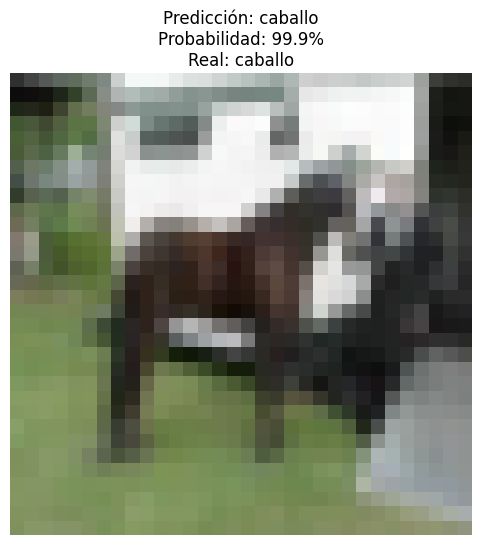

In [8]:
modelo1.eval()

im = rd.randint(0, 29) #Imagenes aleatorias en el conjunto de prueba

#Obtener un lote de prueba
dataiter = iter(cargador_prueba)
imagenes, etiquetas = next(dataiter)

#Seleccionar la imagen a predecir
imagen = imagenes[im].unsqueeze(0).to(dispositivo)  # Añadir dimensión de batch
etiqueta_real = etiquetas[im].item()

#Realizar la predicción
with torch.no_grad():
    salidas = modelo1(imagen)
    probabilidades = torch.nn.functional.softmax(salidas, dim=1)
    prob_predicha, clase_predicha = torch.max(probabilidades, 1)

#Preparar la imagen para visualización
imagen_mostrar = imagen.squeeze().cpu().numpy().transpose((1, 2, 0))  # Convertir a HWC
imagen_mostrar = imagen_mostrar * 0.5 + 0.5  # Desnormalizar ([-1,1] -> [0,1])

#Nombres de las clases
nombres_clases = ['avion', 'automovil', 'pajaro', 'gato', 'ciervo',
                  'perro', 'rana', 'caballo', 'barco', 'camion']

#Crear figura con prediccion
plt.figure(figsize=(6, 6))
plt.imshow(imagen_mostrar)
plt.title(f"Predicción: {nombres_clases[clase_predicha.item()]}\n"
          f"Probabilidad: {prob_predicha.item()*100:.1f}%\n"
          f"Real: {nombres_clases[etiqueta_real]}")
plt.axis('off')
plt.show()

##2. Modelo preentrenado AlexNet


##2.1 Cargar modelo y datos

Para usar el modelo preentrenado lo debemos de cargar y vamos a solo modificar la ultima capa para ajustarlo a la clasificación deseada, en este caso 10 clases.

In [9]:
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {dispositivo}")
# Cargar AlexNet preentrenado y modificarm la ultima capa para las 10 clasificaciones
modelo_pretrain = torchvision.models.alexnet(pretrained=True)
modelo_pretrain.classifier[6] = nn.Linear(4096, 10) #10clases para CIFAR-10
modelo_pretrain = modelo_pretrain.to(dispositivo)

#Preparación de datos especificos para modelo preentrenado
transformaciones_pretrain = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#Cargar datos
cifar_entrenamiento_pretrain = torchvision.datasets.CIFAR10(root='./datos', train=True, download=True, transform=transformaciones_pretrain)
cifar_prueba_pretrain = torchvision.datasets.CIFAR10(root='./datos', train=False, download=True, transform=transformaciones_pretrain)

#Cargadores
cargador_entrenamiento_pretrain = torch.utils.data.DataLoader(cifar_entrenamiento_pretrain, batch_size=30, shuffle=True)
cargador_prueba_pretrain = torch.utils.data.DataLoader(cifar_prueba_pretrain, batch_size=30, shuffle=False)

Usando dispositivo: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 182MB/s]


100%|██████████| 170M/170M [00:05<00:00, 31.4MB/s]


Extracting ./datos/cifar-10-python.tar.gz to ./datos
Files already downloaded and verified


##2.2 Entrenar modelo

Usamos los mismos hiperparámetros y funciones de perdida, el optimizador y las epocas que en el modelo anterior para ser justos.

In [10]:
criterio_pretrain = nn.CrossEntropyLoss()
optimizador_pretrain = optim.SGD(modelo_pretrain.parameters(), lr=0.001, momentum=0.9)

#Entrenar el modelo
epocas_pretrain = 20
for epoca in range(epocas_pretrain):
    modelo_pretrain.train()
    perdida_acumulada = 0.0

    for entradas, etiquetas in cargador_entrenamiento_pretrain:
        entradas = entradas.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)

        optimizador_pretrain.zero_grad()
        salidas = modelo_pretrain(entradas)
        perdida = criterio_pretrain(salidas, etiquetas)
        perdida.backward()
        optimizador_pretrain.step()

        perdida_acumulada += perdida.item()

    print(f'Época {epoca+1}, Pérdida: {perdida_acumulada/len(cargador_entrenamiento_pretrain):.4f}')


Época 1, Pérdida: 0.6339
Época 2, Pérdida: 0.4018
Época 3, Pérdida: 0.3134
Época 4, Pérdida: 0.2524
Época 5, Pérdida: 0.2093
Época 6, Pérdida: 0.1730
Época 7, Pérdida: 0.1421
Época 8, Pérdida: 0.1171
Época 9, Pérdida: 0.0987
Época 10, Pérdida: 0.0842
Época 11, Pérdida: 0.0732
Época 12, Pérdida: 0.0642
Época 13, Pérdida: 0.0566
Época 14, Pérdida: 0.0496
Época 15, Pérdida: 0.0433
Época 16, Pérdida: 0.0423
Época 17, Pérdida: 0.0339
Época 18, Pérdida: 0.0350
Época 19, Pérdida: 0.0311
Época 20, Pérdida: 0.0276


##2.3 Evaluación del desempeño del modelo

Probemos como se desempeña ante datos nuevos el modelo entrenado con las imagenes de _CIFAR 10_

In [11]:
#Evaluar el modelo en el conjunto de prueba
modelo_pretrain.eval()
correctas = 0
total = 0

with torch.no_grad():#Desactiva calculo de gradientes para evaluación
    for datos, etiquetas in cargador_prueba_pretrain:
        datos = datos.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)

        #Obtener predicciones
        salidas = modelo_pretrain(datos)
        _, predichas = torch.max(salidas.data, 1)

        #Calcular metricas
        total += etiquetas.size(0)
        correctas += (predichas == etiquetas).sum().item()

#Calculamos y mostramos la precisión en el conjunto de prueba
print(f'\nPrecisión en el conjunto de prueba: {100 * correctas / total:.2f}%')


Precisión en el conjunto de prueba: 91.16%


In [12]:
#Análisis de clasificación
todas_etiquetas = []
todas_predicciones = []

with torch.no_grad():
    for datos, etiquetas in cargador_prueba_pretrain:
        datos = datos.to(dispositivo)
        salidas = modelo_pretrain(datos)
        _, predichas = torch.max(salidas, 1)

        todas_etiquetas.extend(etiquetas.cpu().numpy())
        todas_predicciones.extend(predichas.cpu().numpy())

clases = ['avión', 'auto', 'pájaro', 'gato', 'ciervo',
          'perro', 'rana', 'caballo', 'barco', 'camión']

print("\nReporte de clasificación para modelo preentrenado:")
print(classification_report(
    todas_etiquetas,
    todas_predicciones,
    target_names=clases,
    digits=4
))


Reporte de clasificación para modelo preentrenado:
              precision    recall  f1-score   support

       avión     0.8974    0.9530    0.9243      1000
        auto     0.9273    0.9700    0.9482      1000
      pájaro     0.8843    0.9020    0.8931      1000
        gato     0.8690    0.7760    0.8199      1000
      ciervo     0.9135    0.8980    0.9057      1000
       perro     0.8737    0.8720    0.8729      1000
        rana     0.9402    0.9430    0.9416      1000
     caballo     0.9036    0.9470    0.9248      1000
       barco     0.9549    0.9310    0.9428      1000
      camión     0.9506    0.9240    0.9371      1000

    accuracy                         0.9116     10000
   macro avg     0.9115    0.9116    0.9110     10000
weighted avg     0.9115    0.9116    0.9110     10000



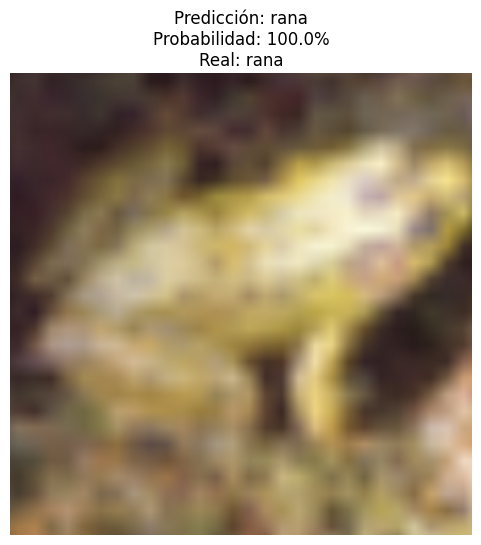

In [14]:
modelo_pretrain.eval()

im = rd.randint(0, 29) #Imagenes aleatorias en el conjunto de prueba

#Obtener un lote de prueba
dataiter_pretrain = iter(cargador_prueba_pretrain)
imagenes_pretrain, etiquetas_pretrain = next(dataiter_pretrain)

#Seleccionar la imagen a predecir
imagen_pretrain = imagenes_pretrain[im].unsqueeze(0).to(dispositivo)
etiqueta_real_pretrain = etiquetas_pretrain[im].item()

#Realizar predicción
with torch.no_grad():
    salidas_pretrain = modelo_pretrain(imagen_pretrain)
    probabilidades_pretrain = torch.nn.functional.softmax(salidas_pretrain, dim=1)
    prob_predicha_pretrain, clase_predicha_pretrain = torch.max(probabilidades_pretrain, 1)

# Preparar imagen para visualización (ajustando desnormalización)
imagen_mostrar_pretrain = imagen_pretrain.squeeze().cpu().numpy().transpose((1, 2, 0))
imagen_mostrar_pretrain = imagen_mostrar_pretrain * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
imagen_mostrar_pretrain = np.clip(imagen_mostrar_pretrain, 0, 1)  # Asegurar valores válidos

# Crear figura
plt.figure(figsize=(6, 6))
plt.imshow(imagen_mostrar_pretrain)
plt.title(f"Predicción: {clases[clase_predicha_pretrain.item()]}\n"
          f"Probabilidad: {prob_predicha_pretrain.item()*100:.1f}%\n"
          f"Real: {clases[etiqueta_real_pretrain]}")
plt.axis('off')
plt.show()

#3. Conclusiones

De los modelos probados, destaca el modelo original de AlexNet por obvias razones, siendo superior. Sin embargo, el modelo creado fue muy bueno considerando las condiciones de tecnologia y recursos computacionales. Para la ejecución se uso la GPU que ofrece Google Colab y se obtuvieron los siguientes resultados.



##3.1 Comparación de Modelos

| Métrica                            | AlexNet creado desde cero | AlexNet preentrenado |
|------------------------------------|---------------------------|----------------------|
| **Tiempo de entrenamiento**        | 10 min                    | 42 min               |             |
| **Pérdida (Época 1)**              | 2.30066                   | 0.6339               |
| **Pérdida (Época 20)**             | 0.31597                   | 0.0276               |
| **Precisión en conjunto de prueba**| **79.22%**                    | **91.16%**  


Podemos notar como con un menor tiempo se obtuvieron buenos resultados con modelo construido desde cero ya que le tomo poco menos de 1/4 de tiempo de lo que le toma realizar 20 epocas al modelo preentrenado de AlexNet.
Una gran diferencia es la ventaja de tener pesos y valores en las capas de convolución del modelo original ya que su perdida inicia en valores muy bajos, como es el caso en esta ejecución donde comenzo en 0.6339. Para datos nuevos, la precisión fue buena, en otras ejecuciones la precisión llego a 86%.

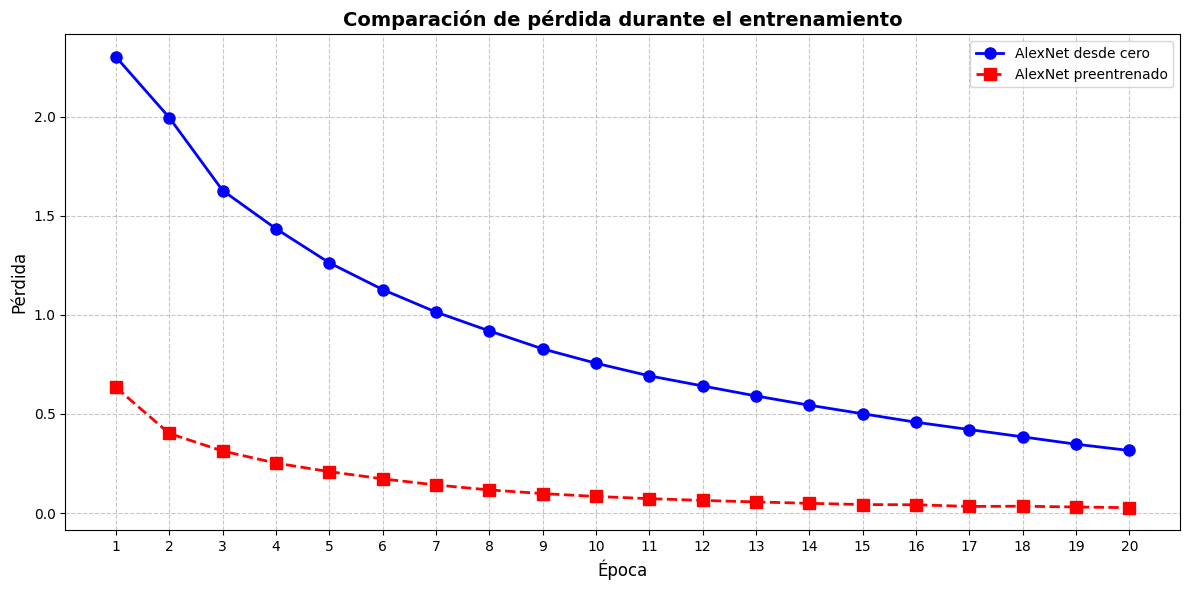

In [17]:
perdida_desde_cero = [
    2.3007, 1.9945, 1.6269, 1.4343, 1.2624,
    1.1276, 1.0140, 0.9189, 0.8283, 0.7559,
    0.6924, 0.6414, 0.5910, 0.5443, 0.5012,
    0.4585, 0.4216, 0.3847, 0.3477, 0.3160
]

perdida_preentrenado = [
    0.6339, 0.4018, 0.3134, 0.2524, 0.2093,
    0.1730, 0.1421, 0.1171, 0.0987, 0.0842,
    0.0732, 0.0642, 0.0566, 0.0496, 0.0433,
    0.0423, 0.0339, 0.0350, 0.0311, 0.0276
]

epocas = range(1, 21)

plt.figure(figsize=(12, 6))

#modelo desde cero
plt.plot(epocas, perdida_desde_cero, 'b-o', label='AlexNet desde cero', linewidth=2, markersize=8)

#modelo preentrenado
plt.plot(epocas, perdida_preentrenado, 'r--s', label='AlexNet preentrenado', linewidth=2, markersize=8)

plt.title('Comparación de pérdida durante el entrenamiento', fontsize=14, fontweight='bold')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.xticks(np.arange(1, 21, step=1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
#plt.yscale('log')
plt.tight_layout()

plt.show()


Metricas de rendimiento
###AlexNet desde cero
| Clase         | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| avión         | 0.8623    | 0.7950 | 0.8273   | 1000    |
| auto          | 0.8973    | 0.9090 | 0.9031   | 1000    |
| pájaro        | 0.8505    | 0.6260 | 0.7212   | 1000    |
| gato          | 0.6155    | 0.5810 | 0.5977   | 1000    |
| ciervo        | 0.8085    | 0.7390 | 0.7722   | 1000    |
| perro         | 0.6008    | 0.8550 | 0.7057   | 1000    |
| rana          | 0.9495    | 0.7150 | 0.8157   | 1000    |
| caballo       | 0.7810    | 0.9020 | 0.8371   | 1000    |
| barco         | 0.8495    | 0.9090 | 0.8783   | 1000    |
| camión        | 0.8327    | 0.8910 | 0.8609   | 1000    |
| **accuracy**  | **0.7922**|        |          | 10000   |
| **macro avg** | **0.8048**| **0.7922** | **0.7919** | 10000   |
| **weighted avg** | **0.8048**| **0.7922** | **0.7919** | 10000   |

---
---
###AlexNet Preentrenado
| Clase         | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| avión         | 0.8974    | 0.9530 | 0.9243   | 1000    |
| auto          | 0.9273    | 0.9700 | 0.9482   | 1000    |
| pájaro        | 0.8843    | 0.9020 | 0.8931   | 1000    |
| gato          | 0.8690    | 0.7760 | 0.8199   | 1000    |
| ciervo        | 0.9135    | 0.8980 | 0.9057   | 1000    |
| perro         | 0.8737    | 0.8720 | 0.8729   | 1000    |
| rana          | 0.9402    | 0.9430 | 0.9416   | 1000    |
| caballo       | 0.9036    | 0.9470 | 0.9248   | 1000    |
| barco         | 0.9549    | 0.9310 | 0.9428   | 1000    |
| camión        | 0.9506    | 0.9240 | 0.9371   | 1000    |
| **accuracy**  | **0.9116**|        |          | 10000   |
| **macro avg** | **0.9115**| **0.9116** | **0.9110** | 10000   |
| **weighted avg** | **0.9115**| **0.9116** | **0.9110** | 10000   |


Podemos notar algunas métricas de cómo clasifica el modelo hecho desde cero contra el modelo original. Por ejemplo:
- La precisión indica cuántas de las predicciones que el modelo hizo para una clase específica fueron correctas, siendo superior por 0.11.
- El recall o sensibilidad indica cuántos de los ejemplos reales de una clase fueron correctamente identificados por el modelo, siendo superior en casi la misma medida anterior.

Finalmente, podemos concluir que el modelo en PyTorch es "más rápido de entrenar" para obtener "buenos resultados" con pocos recursos computacionales, ya que incluso se llegó a correr en una PC con CPU y tardó alrededor de 40 a 60 min. Sin embargo, aunque es más tardado el modelo preentrenado para ajustarlo a los datos dados, es excelente para predecir. Debemos notar que el modelo AlexNet tiene varios años y aun así es eficiente; sin embargo, con más poder computacional se podría mejorar más el modelo, incluso creándolo desde cero.

